Shahab Najafian

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.regularizers import l1_l2

import warnings
warnings.filterwarnings("ignore")

Part 1. Data Preparation and Preprocessing

In [ ]:
# Read train.csv file
train = pd.read_csv('train.csv', header = 0)

In [ ]:
# Define parse_timestamp function
def parse_timestamp(ts):
    try:
        return datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S.%f')
    except ValueError:
        return datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S')

In [ ]:
# Apply the parse_timestamp function to the timestamp column
train['timestamp'] = train['timestamp'].apply(parse_timestamp)

# Sort and set the index of train dataframe
train.sort_values(['asset_id','timestamp'], ascending = [True, True], inplace = True)
train.reset_index(drop = True, inplace = True)
train.set_index(['asset_id','timestamp'], inplace = True)

In [ ]:
train.tail()

roi  \
asset_id                             timestamp                        
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900  False   
                                     2023-11-05 13:12:43.920  False   
                                     2023-11-05 13:12:43.940  False   
                                     2023-11-05 13:12:43.960  False   
                                     2023-11-05 13:12:43.980  False   

                                                              indicator_1a  \
asset_id                             timestamp                               
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900        -867.0   
                                     2023-11-05 13:12:43.920       -1397.0   
                                     2023-11-05 13:12:43.940       -1727.0   
                                     2023-11-05 13:12:43.960       -1339.0   
                                     2023-11-05 13:12:43.980       -1339.0   

                                                              indicator_1b  \
asset_id                             timestamp                               
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900       -2346.0   
                                     2023-11-05 13:12:43.920       -2426.0   
                                     2023-11-05 13:12:43.940       -2355.0   
                                     2023-11-05 13:12:43.960       -2111.0   
                                     2023-11-05 13:12:43.980       -2111.0   

                                                              indicator_1c  \
asset_id                             timestamp                               
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900         470.0   
                                     2023-11-05 13:12:43.920         396.0   
                                     2023-11-05 13:12:43.940         232.0   
                                     2023-11-05 13:12:43.960         133.0   
                                     2023-11-05 13:12:43.980         133.0   

                                                              indicator_1d  \
asset_id                             timestamp                               
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900         582.0   
                                     2023-11-05 13:12:43.920         652.0   
                                     2023-11-05 13:12:43.940        1203.0   
                                     2023-11-05 13:12:43.960        1530.0   
                                     2023-11-05 13:12:43.980        1530.0   

                                                              indicator_1e  \
asset_id                             timestamp                               
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900       -7491.0   
                                     2023-11-05 13:12:43.920       -7408.0   
                                     2023-11-05 13:12:43.940       -7663.0   
                                     2023-11-05 13:12:43.960       -8393.0   
                                     2023-11-05 13:12:43.980       -8393.0   

                                                              indicator_1f  \
asset_id                             timestamp                               
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900        4673.0   
                                     2023-11-05 13:12:43.920        4261.0   
                                     2023-11-05 13:12:43.940        3086.0   
                                     2023-11-05 13:12:43.960        1747.0   
                                     2023-11-05 13:12:43.980        1747.0   

                                                              return_on_asset  \
asset_id                             timestamp                                  
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05 13:12:43.900               30   
                                     2023

In [ ]:
# Get unique asset_ids
unique_asset_ids = train.index.get_level_values('asset_id').unique()

# Split asset_ids into train and validation sets
train_asset_ids, val_asset_ids = train_test_split(unique_asset_ids, test_size = 0.2, random_state = 93)

# Filter the original DataFrame to create train and validation sets
train_set = train.loc[train.index.get_level_values('asset_id').isin(train_asset_ids)]
val_set = train.loc[train.index.get_level_values('asset_id').isin(val_asset_ids)]

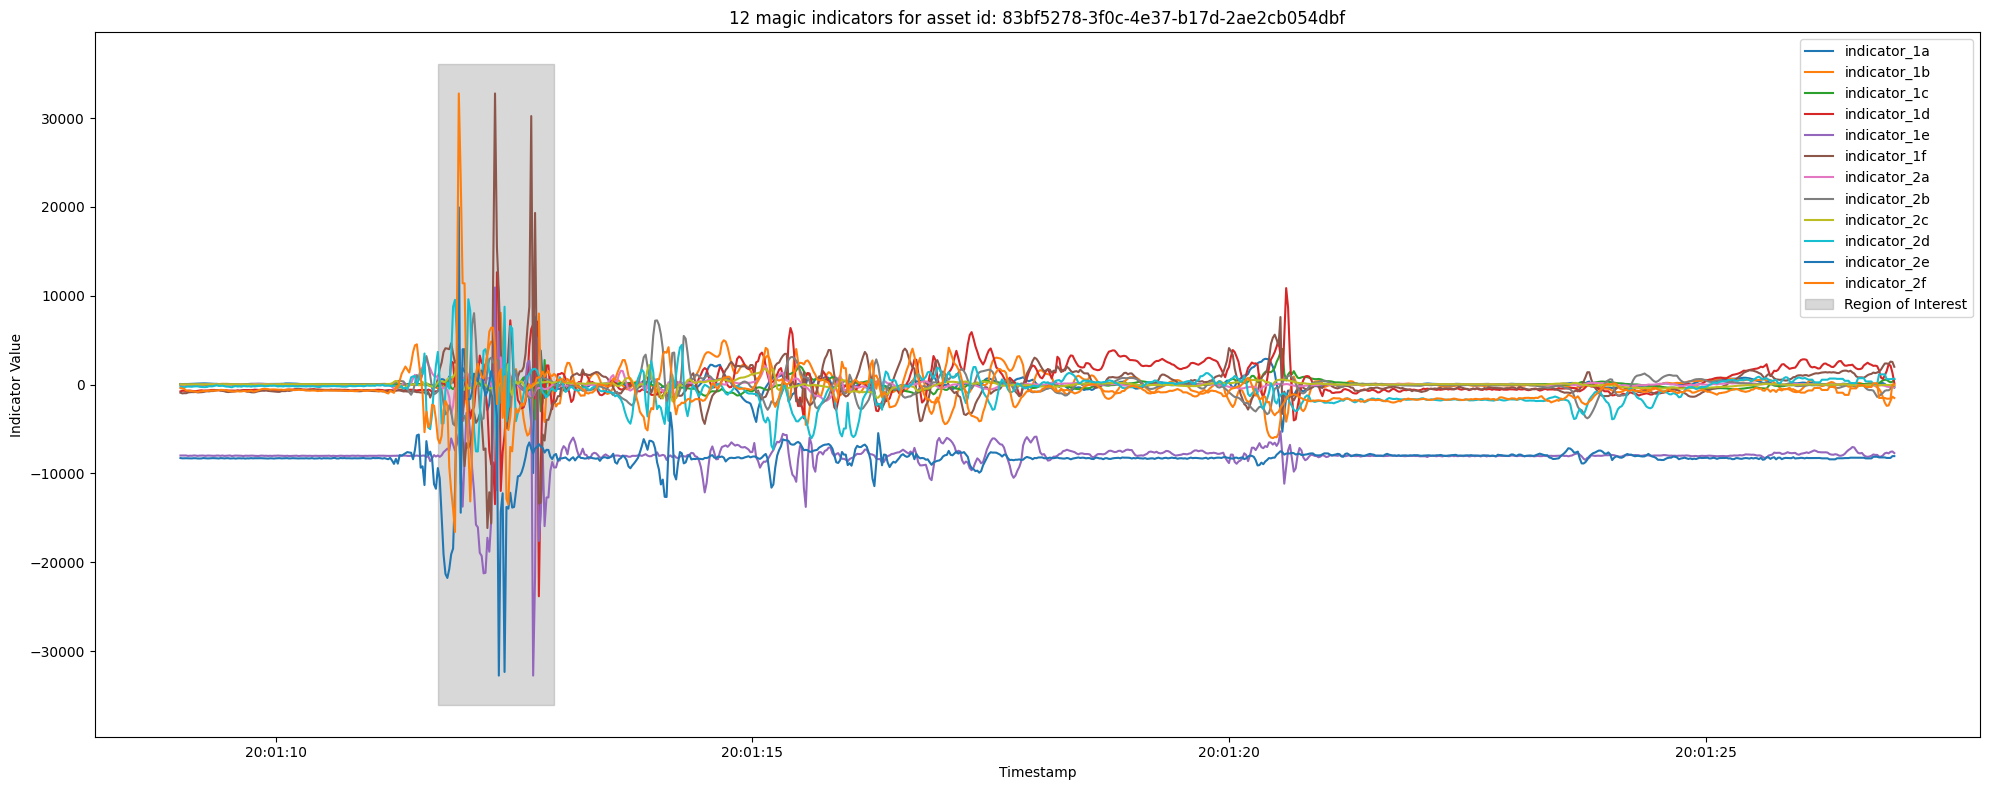

In [ ]:
# Plot the 12 magic indicators for a random asset_id to visualize patterns
# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Extract columns to plot
columns_to_plot = train_set.columns.drop(['company_size', 'company_age', 'revenue', 'roi', 'return_on_asset'])

# Plot the indicators
for column in columns_to_plot:
    ax.plot(train_set.loc[train_asset_ids[0], column], label=column)

ax.set_title(f"12 magic indicators for asset id: {train_asset_ids[0]}")
ax.set_xlabel('Timestamp')
ax.set_ylabel('Indicator Value')

# Shade the area where 'roi' column is True
roi = train_set.loc[train_asset_ids[0], 'roi'].astype(bool)
ax.fill_between(roi.index.get_level_values('timestamp'), ax.get_ylim()[0], ax.get_ylim()[1], where=roi, color='gray', alpha=0.3, label='Region of Interest')

# Display the plots
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Normalize the data
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_set.drop(['roi','return_on_asset'], axis = 1))
train_scaled = pd.DataFrame(train_scaled, index = train_set.index, columns = train_set.columns.drop(['roi','return_on_asset']))
train_scaled = pd.merge(train_scaled, train_set[['roi','return_on_asset']], how = 'left', on = ['asset_id','timestamp'])

val_scaled = scaler.transform(val_set.drop(['roi','return_on_asset'], axis = 1))
val_scaled = pd.DataFrame(val_scaled, index = val_set.index, columns = val_set.columns.drop(['roi','return_on_asset']))
val_scaled = pd.merge(val_scaled, val_set[['roi','return_on_asset']], how = 'left', on = ['asset_id','timestamp'])

# Fill NA values with 0
train_scaled.fillna(0, inplace = True)
val_scaled.fillna(0, inplace = True)

In [ ]:
# Separate features and target for the classification
col_drop_class = ['roi','company_age','company_size','revenue','return_on_asset','indicator_1b','indicator_1c','indicator_2b','indicator_2c']

X_train_class_scaled = train_scaled.drop(columns = col_drop_class, axis = 1)
y_train_class = train_scaled[['roi']]

X_val_class_scaled = val_scaled.drop(columns = col_drop_class, axis = 1)
y_val_class = val_scaled[['roi']]

# Separate features and target for the Regression
col_drop_reg = ['return_on_asset']#,'company_age','indicator_2a','indicator_2b','indicator_2c','indicator_2d','indicator_2e','indicator_2f']

X_train_reg_scaled = train_scaled.drop(columns = col_drop_reg, axis = 1)
X_train_reg_scaled = X_train_reg_scaled[X_train_reg_scaled['roi'] == True]
X_train_reg_scaled.drop('roi', axis = 1, inplace = True)
y_train_reg = train_scaled[['return_on_asset']]
#y_train_reg = y_train_reg.reset_index().drop('timestamp', axis = 1).drop_duplicates(subset = 'asset_id').set_index('asset_id')

X_val_reg_scaled = val_scaled.drop(columns = col_drop_reg, axis = 1)
X_val_reg_scaled = X_val_reg_scaled[X_val_reg_scaled['roi'] == True]
X_val_reg_scaled.drop('roi', axis = 1, inplace = True)
y_val_reg = val_scaled[['return_on_asset']]
#y_val_reg = y_val_reg.reset_index().drop('timestamp', axis = 1).drop_duplicates(subset = 'asset_id').set_index('asset_id')

In [ ]:
# Set seeds for reproducibility
np.random.seed(93)
tf.random.set_seed(93)
random.seed(93)

Part 2. Classification: Pedicting Region of Interest

RNN (LSTM)

In [ ]:
# Define reshape_for_rnn function to reshape the data for RNN
def reshape_for_rnn(data, time_steps, target = False):
    data_rnn = []
    for asset_id in data.index.get_level_values('asset_id').unique():
        asset_data = data.loc[asset_id].values
        for i in range(time_steps, len(asset_data)):
            if target == True:
                data_rnn.append(asset_data[i])
            else:
                data_rnn.append(asset_data[i-time_steps:i])
    return np.array(data_rnn)

# Reshape the data for RNN
time_steps_rnn = 60

X_train_rnn = reshape_for_rnn(X_train_class_scaled, time_steps_rnn, target = False)
y_train_rnn = reshape_for_rnn(y_train_class, time_steps_rnn, target = True)

X_val_rnn = reshape_for_rnn(X_val_class_scaled, time_steps_rnn, target = False)
y_val_rnn = reshape_for_rnn(y_val_class, time_steps_rnn, target = True)

In [ ]:
#20-30-20
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(16, return_sequences=True, kernel_regularizer=l2(0.01)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(16))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Precision', 'Recall'])

# Fit the model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train_rnn, y_train_rnn, epochs=40, batch_size=128, validation_data=(X_val_rnn, y_val_rnn), callbacks=[early_stopping])

# Evaluate the model
loss, precision, recall = model_lstm.evaluate(X_val_rnn, y_val_rnn)
y_val_pred_lstm = (model_lstm.predict(X_val_rnn) > 0.5).astype("int32")

# Calculate and print classification metrics
f1 = 2 * (precision * recall) / (precision + recall)
roc_auc = roc_auc_score(y_val_rnn, y_val_pred_lstm)

print(f"LSTM Validation Precision: {precision}")
print(f"LSTM Validation Recall: {recall}")
print(f"LSTM Validation F1 Score: {f1}")
print(f"LSTM Validation ROC-AUC: {roc_auc}")

Epoch 1/40
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - Precision: 0.7416 - Recall: 0.6340 - loss: 0.2884 - val_Precision: 0.9244 - val_Recall: 0.8727 - val_loss: 0.0759
Epoch 2/40
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - Precision: 0.9198 - Recall: 0.8625 - loss: 0.0767 - val_Precision: 0.9219 - val_Recall: 0.8895 - val_loss: 0.0680
Epoch 3/40
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - Precision: 0.9264 - Recall: 0.8782 - loss: 0.0663 - val_Precision: 0.9235 - val_Recall: 0.8804 - val_loss: 0.0672
Epoch 4/40
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - Precision: 0.9326 - Recall: 0.8826 - loss: 0.0623 - val_Precision: 0.9004 - val_Recall: 0.8938 - val_loss: 0.0660
Epoch 5/40
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - Precision: 0.9328 - Recall: 0.8909 - loss: 0.0577 - val_Precision: 0.9002 - val_Recall: 0.8996 - val_loss: 0.0650
Epoch 6/40
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 91s 52ms/step - Precision: 0.9359 - Recall: 0.8977 - loss: 0.0537 - val_Precision: 0.9013 - val_Re

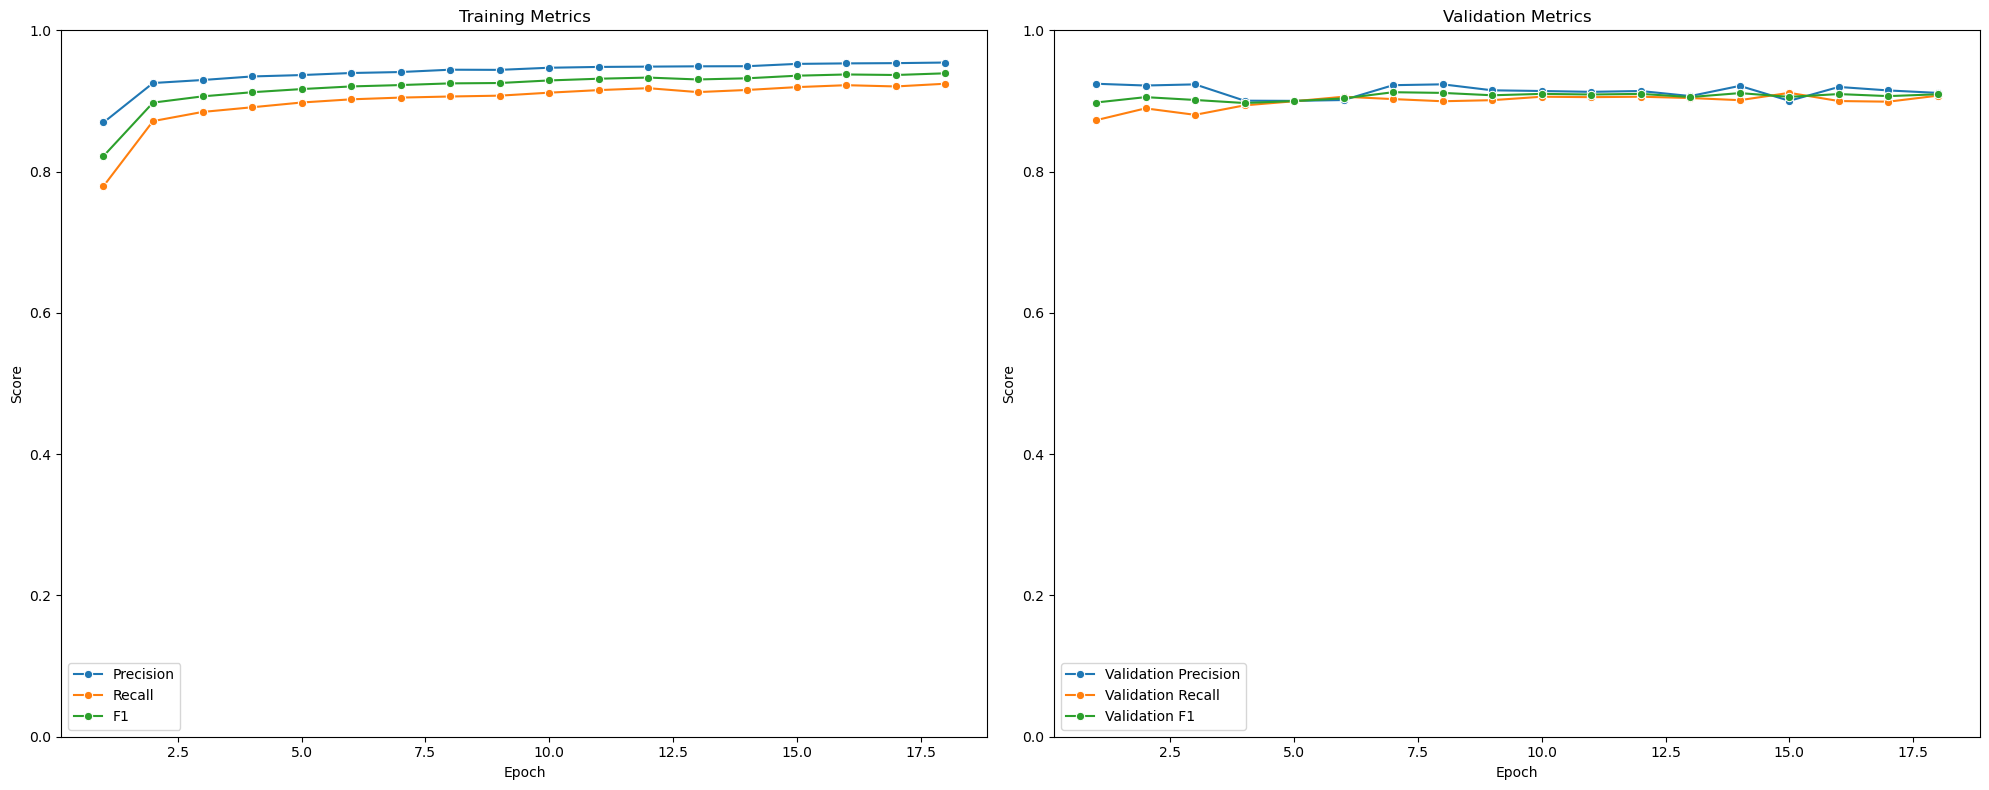

LSTM Final Epoch Validation Precision: 0.9114311933517456
LSTM Final Epoch Validation Recall: 0.9075374007225037
LSTM Final Epoch Validation F1 Score: 0.9094801293947891
LSTM Validation ROC-AUC: 0.9460813416857414


In [ ]:
# Extract metrics from the training history
precision_history = history_lstm.history['Precision']
recall_history = history_lstm.history['Recall']
val_precision_history = history_lstm.history['val_Precision']
val_recall_history = history_lstm.history['val_Recall']

# Create a DataFrame for better visualization
epochs = range(1, len(precision_history) + 1)
metrics_df = pd.DataFrame({
    'Epoch': epochs,
    'Precision': precision_history,
    'Recall': recall_history,
    'Val_Precision': val_precision_history,
    'Val_Recall': val_recall_history
})

# Calculate F1 scores for each epoch
metrics_df['F1'] = 2 * (metrics_df['Precision'] * metrics_df['Recall']) / (metrics_df['Precision'] + metrics_df['Recall'])
metrics_df['Val_F1'] = 2 * (metrics_df['Val_Precision'] * metrics_df['Val_Recall']) / (metrics_df['Val_Precision'] + metrics_df['Val_Recall'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot Precision, Recall, and F1 Score
sns.lineplot(x='Epoch', y='Precision', data=metrics_df, marker='o', ax=ax1, label='Precision')
sns.lineplot(x='Epoch', y='Recall', data=metrics_df, marker='o', ax=ax1, label='Recall')
sns.lineplot(x='Epoch', y='F1', data=metrics_df, marker='o', ax=ax1, label='F1')
ax1.set_title('Training Metrics')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.legend()

# Plot Validation Precision, Recall, and F1 Score
sns.lineplot(x='Epoch', y='Val_Precision', data=metrics_df, marker='o', ax=ax2, label='Validation Precision')
sns.lineplot(x='Epoch', y='Val_Recall', data=metrics_df, marker='o', ax=ax2, label='Validation Recall')
sns.lineplot(x='Epoch', y='Val_F1', data=metrics_df, marker='o', ax=ax2, label='Validation F1')
ax2.set_title('Validation Metrics')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_ylim(0, 1)
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Print final epoch's validation metrics
final_epoch_metrics = metrics_df.iloc[-1]
print(f"LSTM Final Epoch Validation Precision: {final_epoch_metrics['Val_Precision']}")
print(f"LSTM Final Epoch Validation Recall: {final_epoch_metrics['Val_Recall']}")
print(f"LSTM Final Epoch Validation F1 Score: {final_epoch_metrics['Val_F1']}")

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_val_rnn, y_val_pred_lstm)
print(f"LSTM Validation ROC-AUC: {roc_auc}")

1128/1128 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


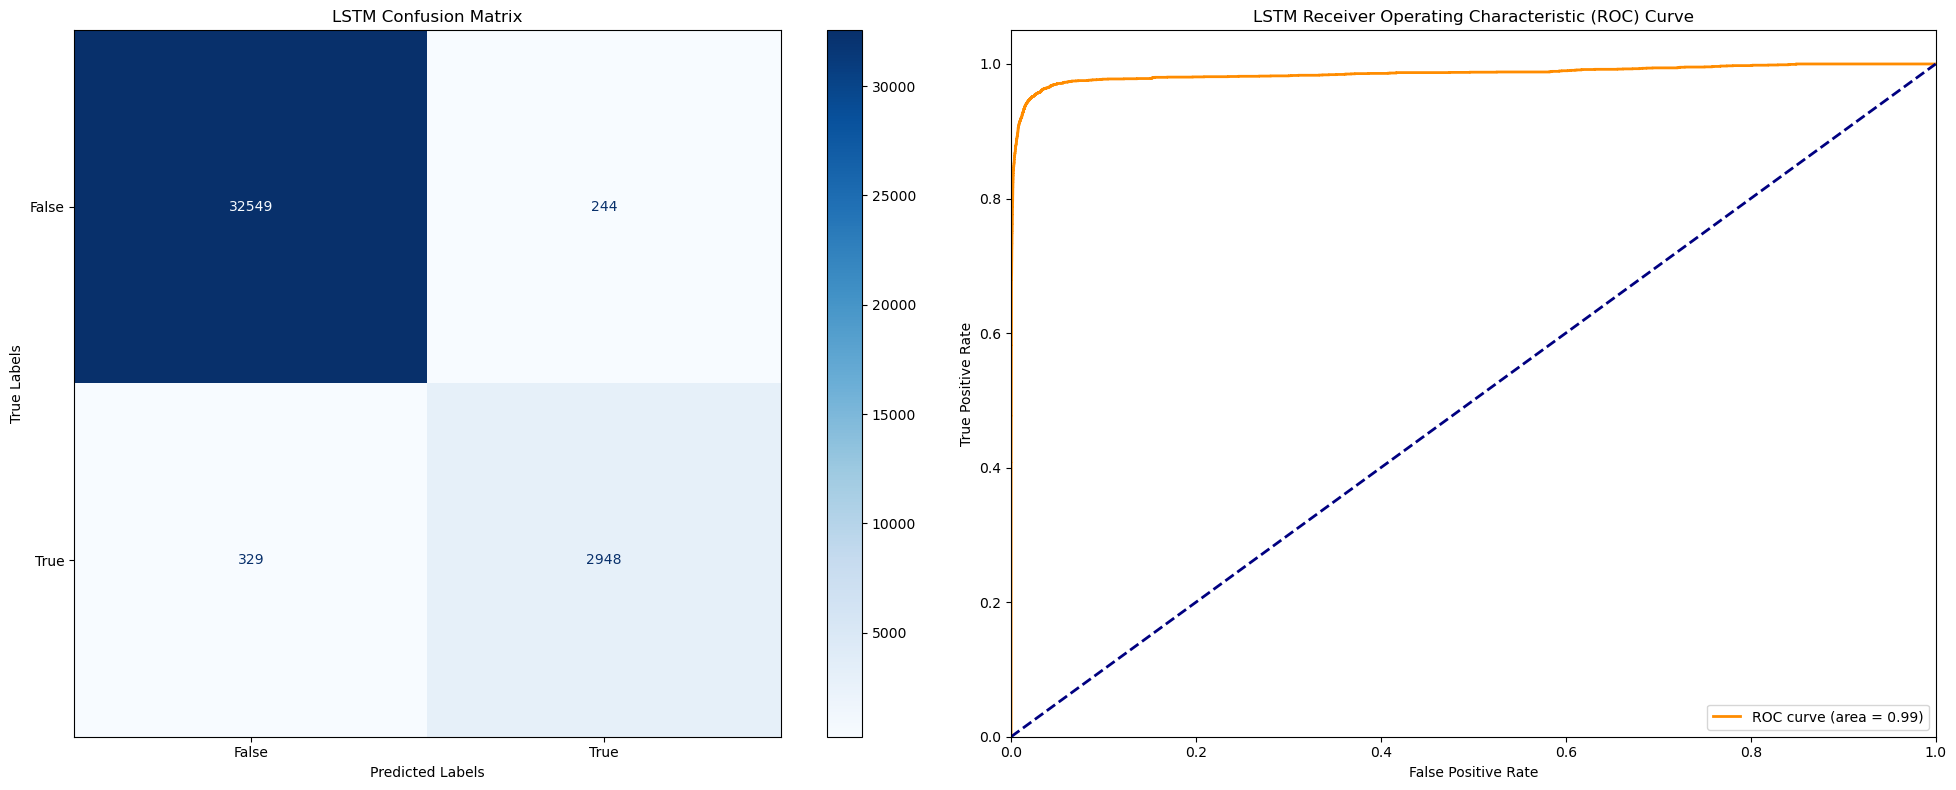

In [ ]:
# Create the confusion matrix for the LSTM model
conf_matrix_lstm = confusion_matrix(y_val_rnn, y_val_pred_lstm)

# Create the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lstm, display_labels=['False', 'True'])
disp.plot(cmap='Blues', ax=ax[0])
ax[0].set_title('LSTM Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Calculate ROC AUC Curve
y_val_pred_proba_lstm = model_lstm.predict(X_val_rnn).ravel()
fpr, tpr, thresholds = roc_curve(y_val_rnn, y_val_pred_proba_lstm)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC Curve
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('LSTM Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Display the plots
plt.tight_layout()
plt.show()

Random Forest Classifier

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100,200,300],
    'criterion': ['gini','entropy','log_loss'],
    'max_features': ['sqrt','log2'],
    'max_depth': [10,15,20,25,30],
    'min_samples_split': [2,5,8],
    'min_samples_leaf': [1,3,5],
    'class_weight': ['balanced', 'balanced_subsample',None]
}

# Create a RandomForestClassifier
rfc = RandomForestClassifier(random_state = 93)

# Set up GridSearchCV with StratifiedKFold
skf = StratifiedKFold(n_splits=5)
grid_search_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = skf, scoring='f1', n_jobs = -1, verbose = 2)

# Fit the model
grid_search_rfc.fit(X_train_class_scaled, y_train_class)

# Get the best parameters and score
best_params_rfc = grid_search_rfc.best_params_
best_score_rfc = grid_search_rfc.best_score_

print(f"Random Forest Classifier Best Parameters: {best_params_rfc}")
print(f"Random Forest Classifier Best Score: {best_score_rfc}")

# Evaluate the best model on the validation set
best_model_rfc = grid_search_rfc.best_estimator_
y_val_pred_rfc = best_model_rfc.predict(X_val_class_scaled)
y_val_pred_proba_rfc = best_model_rfc.predict_proba(X_val_class_scaled)[:, 1]

# Calculate and print classification metrics
precision = precision_score(y_val_class, y_val_pred_rfc, average='binary')
recall = recall_score(y_val_class, y_val_pred_rfc, average='binary')
f1 = f1_score(y_val_class, y_val_pred_rfc, average='binary')
roc_auc = roc_auc_score(y_val_class, y_val_pred_proba_rfc)

print(f"Random Forest Classifier Validation Precision: {precision}")
print(f"Random Forest Classifier Validation Recall: {recall}")
print(f"Random Forest Classifier Validation F1 Score: {f1}")
print(f"Random Forest Classifier Validation ROC-AUC: {roc_auc}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest Classifier Best Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Classifier Best Score: 0.8121522444337769
Random Forest Classifier Validation Precision: 0.8613723441309649
Random Forest Classifier Validation Recall: 0.7546536466280134
Random Forest Classifier Validation F1 Score: 0.8044892648015615
Random Forest Classifier Validation ROC-AUC: 0.979317948735189


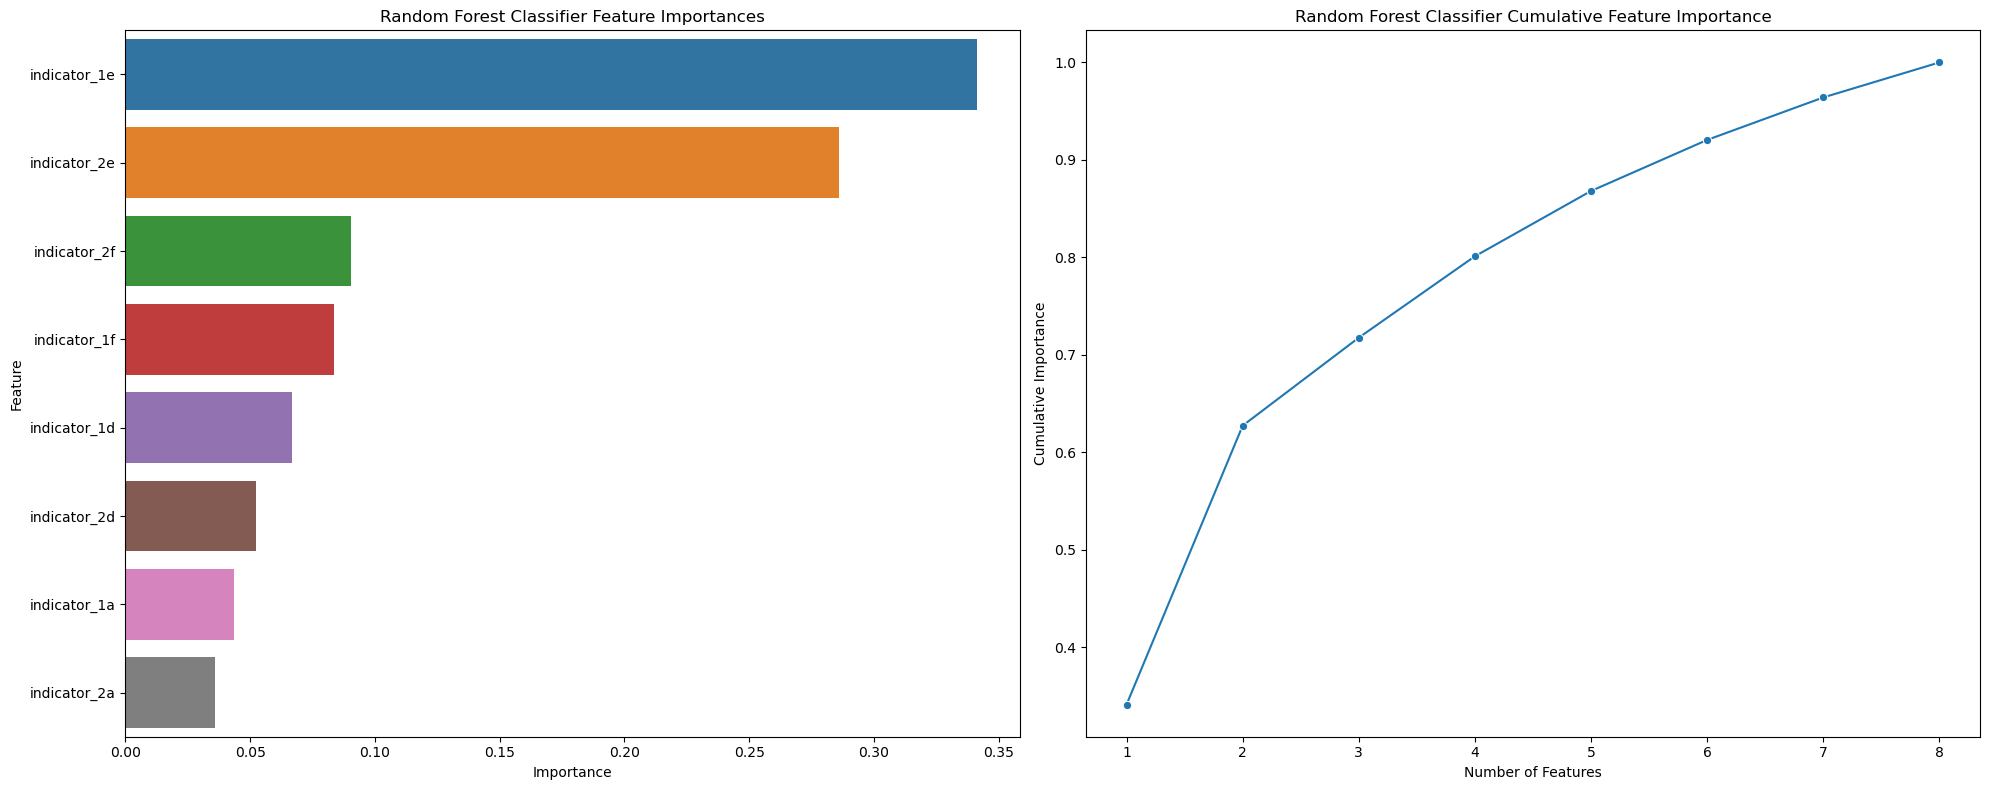

        Feature  Importance  Cumulative Importance
0  indicator_1e    0.341258               0.341258
1  indicator_2e    0.286131               0.627390
2  indicator_2f    0.090266               0.717655
3  indicator_1f    0.083513               0.801168
4  indicator_1d    0.066963               0.868132


In [ ]:
# Get feature importances
feature_importances_rfc = best_model_rfc.feature_importances_

# Create a DataFrame for better visualization
features = X_train_class_scaled.columns
importance_rfc = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rfc})

# Sort the DataFrame by importance and reset the index
importance_rfc = importance_rfc.sort_values(by='Importance', ascending=False)
importance_rfc.reset_index(drop = True, inplace = True)

# Calculate cumulative importance
importance_rfc['Cumulative Importance'] = np.cumsum(importance_rfc['Importance'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the feature importances
sns.barplot(x='Importance', y='Feature', data=importance_rfc, ax=ax1)
ax1.set_title('Random Forest Classifier Feature Importances')

# Plot the cumulative importance
sns.lineplot(x=importance_rfc.index + 1, y='Cumulative Importance', data=importance_rfc, marker='o', ax=ax2)
ax2.set_title('Random Forest Classifier Cumulative Feature Importance')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')

# Display the plots
plt.tight_layout()
plt.show()

# Print the top 5 features
print(importance_rfc.head())

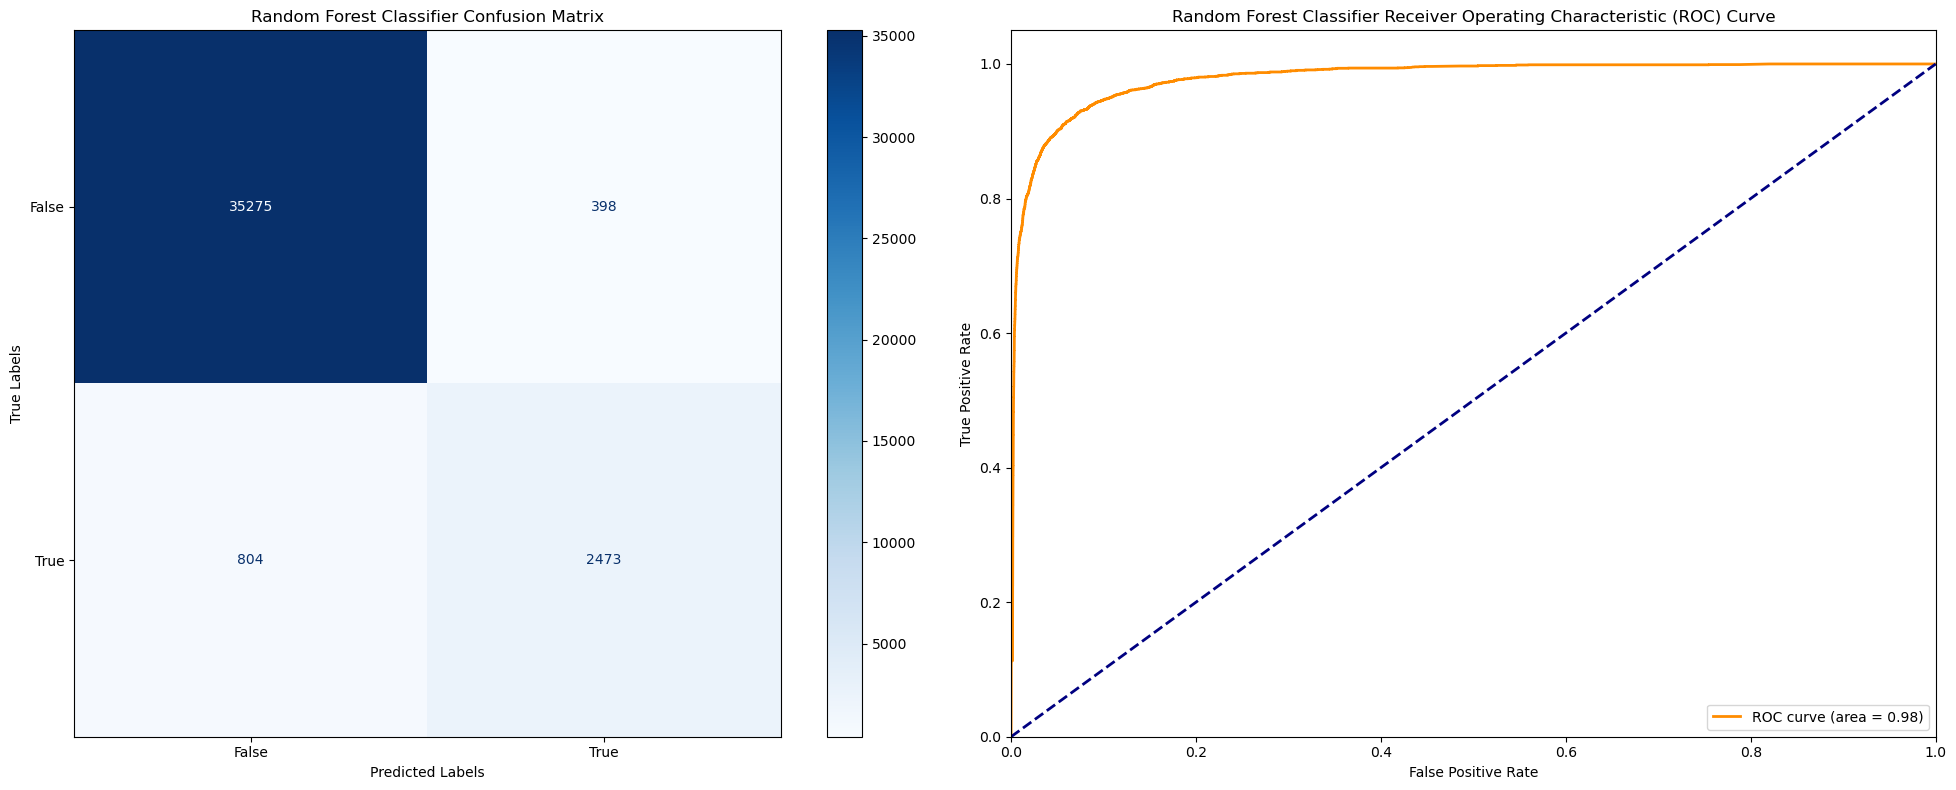

In [ ]:
# Create the confusion matrix
conf_matrix_rfc = confusion_matrix(y_val_class, y_val_pred_rfc)

# Create the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rfc, display_labels=['False', 'True'])
disp.plot(cmap='Blues', ax=ax[0])
ax[0].set_title('Random Forest Classifier Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Calculate ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_val_class, y_val_pred_proba_rfc)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC Curve
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Random Forest Classifier Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Display the plots
plt.tight_layout()
plt.show()

Gradient Boosting Classifier

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100,200,300],
    'learning_rate': [0.01,0.1,0.2],
    'loss': ['log_loss','exponential'],
    'criterion': ['friedman_mse','squared_error'],
    'max_depth': [10,15,20,25,30],
    'min_samples_split': [2,5,8],
    'min_samples_leaf': [1,3,5],
    'max_features': ['sqrt','log2'],
    'subsample': [0.6,0.8,1]
}

# Create a GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=93)

# Set up GridSearchCV with StratifiedKFold
skf = StratifiedKFold(n_splits=5)
grid_search_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=2)

# Fit the model
grid_search_gbc.fit(X_train_class_scaled, y_train_class)

# Get the best parameters and score
best_params_gbc = grid_search_gbc.best_params_
best_score_gbc = grid_search_gbc.best_score_

print(f"Gradient Boosting Classifier Best Parameters: {best_params_gbc}")
print(f"Gradient Boosting Classifier Best F1 Score: {best_score_gbc}")

# Evaluate the best model on the validation set
best_model_gbc = grid_search_gbc.best_estimator_
y_val_pred_gbc = best_model_gbc.predict(X_val_class_scaled)
y_val_pred_proba_gbc = best_model_gbc.predict_proba(X_val_class_scaled)[:, 1]

# Calculate and print classification metrics
precision = precision_score(y_val_class, y_val_pred_gbc, average='binary')
recall = recall_score(y_val_class, y_val_pred_gbc, average='binary')
f1 = f1_score(y_val_class, y_val_pred_gbc, average='binary')
roc_auc = roc_auc_score(y_val_class, y_val_pred_proba_gbc)

print(f"Gradient Boosting Classifier Validation Precision: {precision}")
print(f"Gradient Boosting Classifier Validation Recall: {recall}")
print(f"Gradient Boosting Classifier Validation F1 Score: {f1}")
print(f"Gradient Boosting Classifier Validation ROC-AUC: {roc_auc}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Gradient Boosting Classifier Best Parameters: {'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1}
Gradient Boosting Classifier Best F1 Score: 0.8131421056419924
Gradient Boosting Classifier Validation Precision: 0.8453914767096135
Gradient Boosting Classifier Validation Recall: 0.7808971620384498
Gradient Boosting Classifier Validation F1 Score: 0.8118654822335025
Gradient Boosting Classifier Validation ROC-AUC: 0.9819921478298184


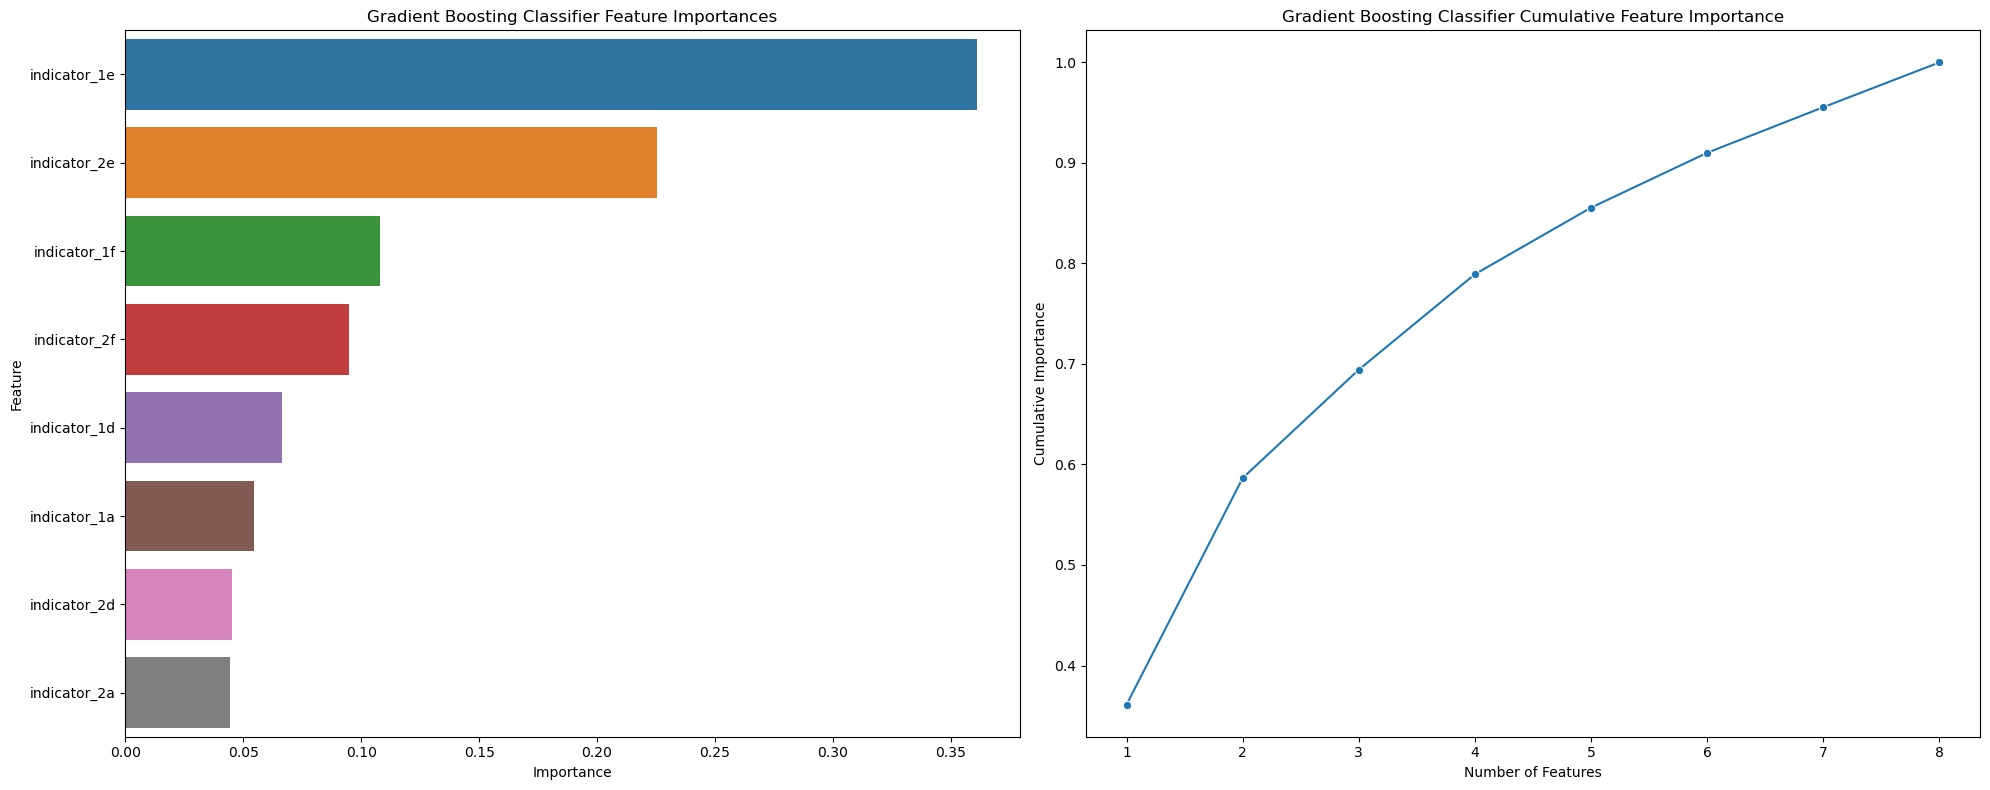

        Feature  Importance  Cumulative Importance
0  indicator_1e    0.361088               0.361088
1  indicator_2e    0.225367               0.586456
2  indicator_1f    0.107868               0.694323
3  indicator_2f    0.094966               0.789289
4  indicator_1d    0.066224               0.855513


In [ ]:
# Get feature importances
feature_importances_gbc = best_model_gbc.feature_importances_

# Create a DataFrame for better visualization
features = X_train_class_scaled.columns
importance_gbc = pd.DataFrame({'Feature': features, 'Importance': feature_importances_gbc})

# Sort the DataFrame by importance and reset the index
importance_gbc = importance_gbc.sort_values(by='Importance', ascending=False)
importance_gbc.reset_index(drop = True, inplace = True)

# Calculate cumulative importance
importance_gbc['Cumulative Importance'] = np.cumsum(importance_gbc['Importance'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the feature importances
sns.barplot(x='Importance', y='Feature', data=importance_gbc, ax=ax1)
ax1.set_title('Gradient Boosting Classifier Feature Importances')

# Plot the cumulative importance
sns.lineplot(x=importance_gbc.index + 1, y='Cumulative Importance', data=importance_gbc, marker='o', ax=ax2)
ax2.set_title('Gradient Boosting Classifier Cumulative Feature Importance')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')

# Display the plots
plt.tight_layout()
plt.show()

# Print the top 5 features
print(importance_gbc.head())

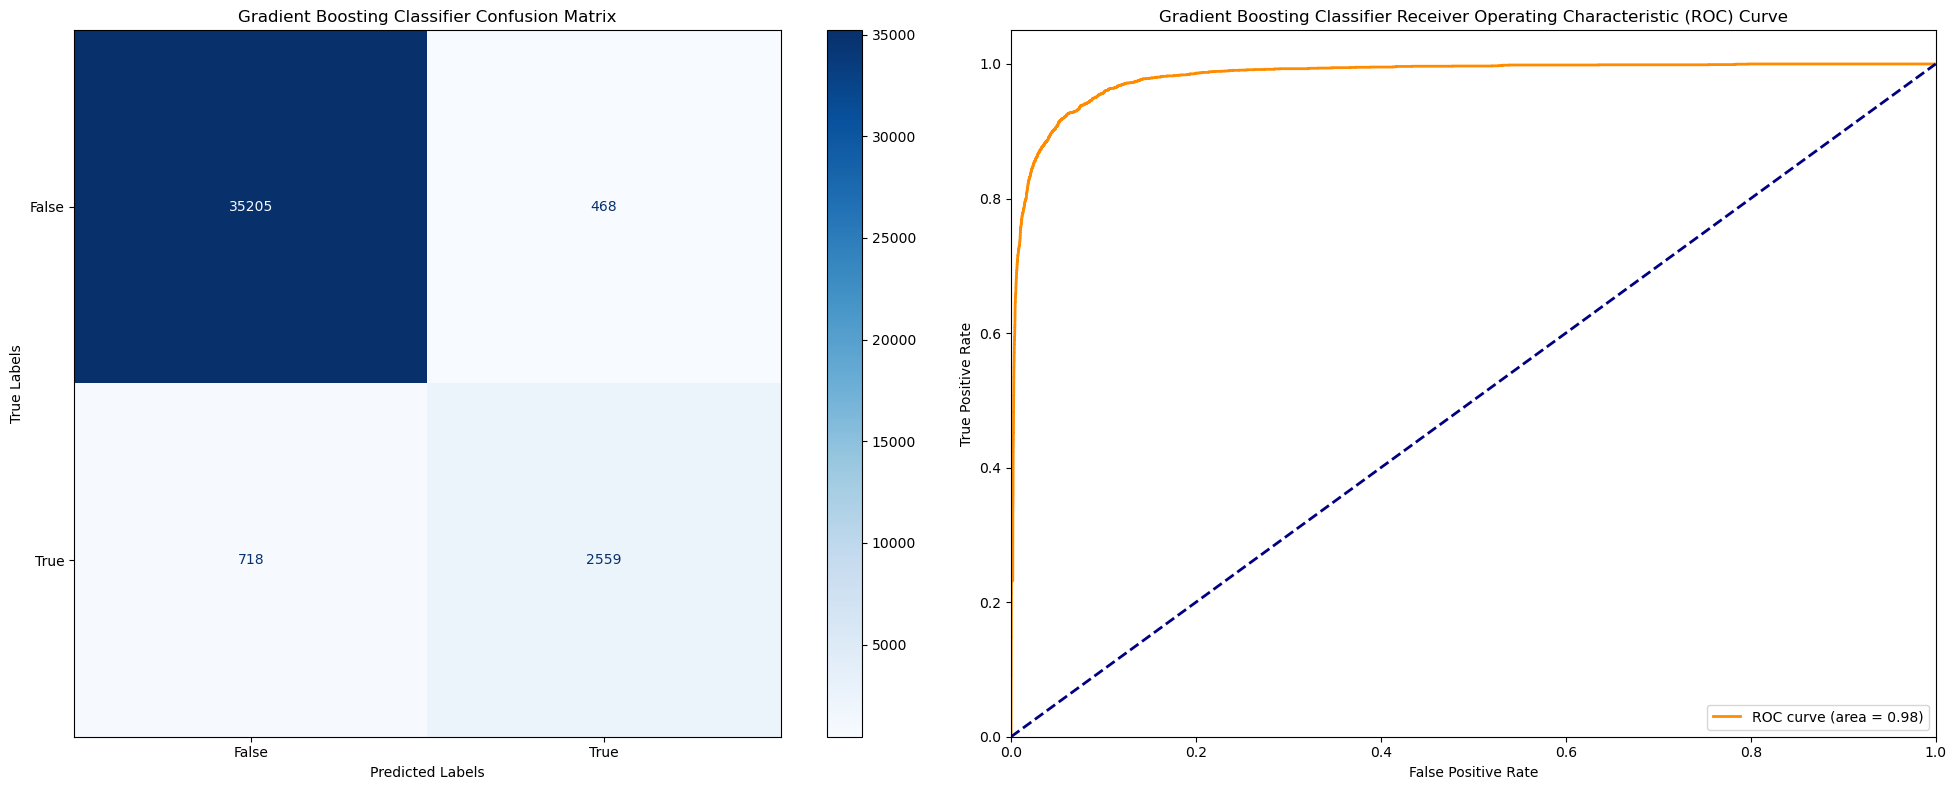

In [ ]:
# Create the confusion matrix
conf_matrix_gbc = confusion_matrix(y_val_class, y_val_pred_gbc)

# Create the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gbc, display_labels=['False', 'True'])
disp.plot(cmap='Blues', ax=ax[0])
ax[0].set_title('Gradient Boosting Classifier Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Calculate ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_val_class, y_val_pred_proba_gbc)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC Curve
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Gradient Boosting Classifier Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Display the plots
plt.tight_layout()
plt.show()

Part 3. Regression: Predicting Return on Asset

In [ ]:
# Engineer the features
agg_funcs = ['min', 'max', 'std', 'skew']
agg_dict = {col: agg_funcs for col in X_train_reg_scaled.columns if col.startswith('indicator_')}
agg_dict.update({'company_size': ['mean'], 'revenue': ['mean']})

X_train_reg_scaled_agg = X_train_reg_scaled.groupby('asset_id').agg(agg_dict).reset_index()
X_val_reg_scaled_agg = X_val_reg_scaled.groupby('asset_id').agg(agg_dict).reset_index()

# Flatten multi-level column names
X_train_reg_scaled_agg.set_index('asset_id', inplace=True)
X_train_reg_scaled_agg.columns = ['_'.join(col).strip() for col in X_train_reg_scaled_agg.columns.values]
X_val_reg_scaled_agg.set_index('asset_id', inplace=True)
X_val_reg_scaled_agg.columns = ['_'.join(col).strip() for col in X_val_reg_scaled_agg.columns.values]

Random Forest Regressor

In [ ]:
y_train_reg_agg = y_train_reg.reset_index().drop('timestamp', axis = 1).drop_duplicates(subset = 'asset_id').set_index('asset_id')
y_val_reg_agg = y_val_reg.reset_index().drop('timestamp', axis = 1).drop_duplicates(subset = 'asset_id').set_index('asset_id')

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100,200,300],
    'criterion': ['absolute_error','squared_error','friedman_mse'],
    'max_features': ['sqrt','log2'],
    'max_depth': [15,20,25,30],
    'min_samples_split': [2,5,8],
    'min_samples_leaf': [1,3,5],
    'bootstrap': [True, False]
}

# Create a RandomForestRegressor
rfr = RandomForestRegressor(random_state = 93)

# Set up GridSearchCV
grid_search_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1, verbose = 2)

# Fit the model
grid_search_rfr.fit(X_train_reg_scaled_agg, y_train_reg_agg)

# Get the best parameters and score
best_params_rfr = grid_search_rfr.best_params_
best_score_rfr = grid_search_rfr.best_score_

print(f"Random Forest Regressor Best Parameters: {best_params_rfr}")
print(f"Random Forest Regressor Best Score: {best_score_rfr}")

# Evaluate the best model on the validation set
best_model_rfr = grid_search_rfr.best_estimator_
y_val_pred_rfr = best_model_rfr.predict(X_val_reg_scaled_agg)
val_mae_rfr = mean_absolute_error(y_val_reg_agg, y_val_pred_rfr)
print(f"Random Forest Regressor Validation MAE: {val_mae_rfr}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Random Forest Regressor Best Parameters: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Regressor Best Score: -5.516947368421053
Random Forest Regressor Validation MAE: 4.421927083333333


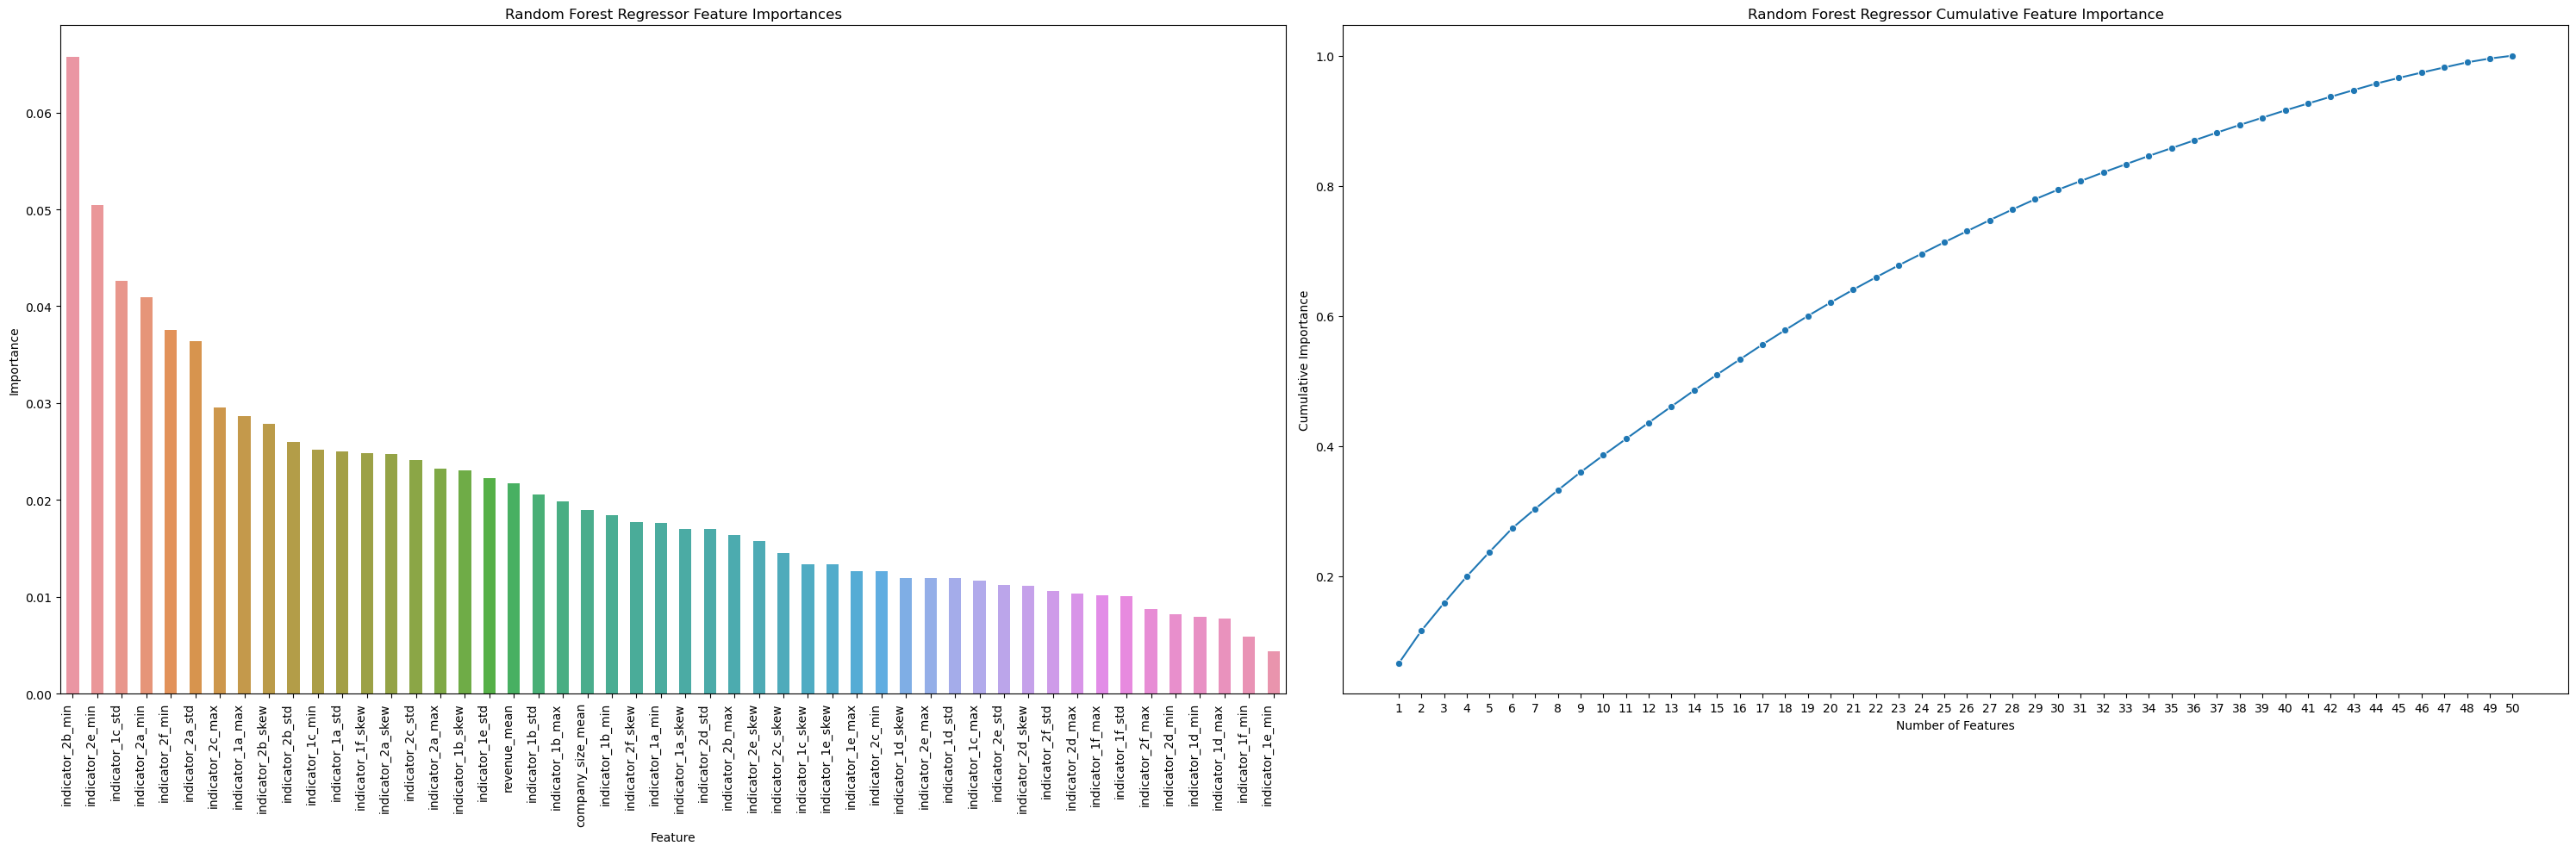

            Feature  Importance  Cumulative Importance
0  indicator_2b_min    0.065716               0.065716
1  indicator_2e_min    0.050421               0.116138
2  indicator_1c_std    0.042640               0.158778
3  indicator_2a_min    0.040912               0.199690
4  indicator_2f_min    0.037597               0.237287


In [ ]:
# Get feature importances
feature_importances_rfr = best_model_rfr.feature_importances_

# Create a DataFrame for better visualization
features = X_train_reg_scaled_agg.columns
importance_rfr = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rfr})

# Sort the DataFrame by importance and reset the index
importance_rfr = importance_rfr.sort_values(by='Importance', ascending=False)
importance_rfr.reset_index(drop=True, inplace=True)

# Calculate cumulative importance
importance_rfr['Cumulative Importance'] = np.cumsum(importance_rfr['Importance'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# Plot the feature importances
sns.barplot(x='Feature', y='Importance', data=importance_rfr, ax=ax1, width=0.5)
ax1.set_title('Random Forest Regressor Feature Importances')
ax1.tick_params(axis='x', rotation=90)

# Adjust the bar width and spacing
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
ax1.set_xlim(-0.5, len(importance_rfr) - 0.5)

# Plot the cumulative importance
sns.lineplot(x=range(1, len(importance_rfr) + 1), y='Cumulative Importance', data=importance_rfr, marker='o', ax=ax2)
ax2.set_title('Random Forest Regressor Cumulative Feature Importance')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')

# Include all feature indices as x labels
ax2.set_xticks(range(1, len(importance_rfr) + 1))
ax2.set_xticklabels(range(1, len(importance_rfr) + 1))

# Adjust layout to fit labels
plt.tight_layout()
plt.show()

# Print the top 5 features
print(importance_rfr.head())

Gradient Boosting Regressor

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100,200,300],
    'loss': ['absolute_error',],
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.1],
    'max_depth': [10,15],
    'min_samples_split': [5,10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'subsample': [0.8, 1.0]
}

# Create a GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state = 93)

# Set up GridSearchCV
grid_search_gbr = GridSearchCV(estimator = gbr, param_grid = param_grid, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1, verbose = 2)

# Fit the model
grid_search_gbr.fit(X_train_reg_scaled_agg, y_train_reg_agg)

# Get the best parameters and score
best_params_gbr = grid_search_gbr.best_params_
best_score_gbr = grid_search_gbr.best_score_

print(f"Gradient Boosting Regressor Best Parameters: {best_params_gbr}")
print(f"Gradient Boosting Regressor Best Score: {best_score_gbr}")

# Evaluate the best model on the validation set
best_model_gbr = grid_search_gbr.best_estimator_
y_val_pred_gbr = best_model_gbr.predict(X_val_reg_scaled_agg)
val_mae_gbr = mean_absolute_error(y_val_reg_agg, y_val_pred_gbr)
print(f"Gradient Boosting Regressor Validation MAE: {val_mae_gbr}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Gradient Boosting Regressor Best Parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.8}
Gradient Boosting Regressor Best Score: -5.302373026683773
Gradient Boosting Regressor Validation MAE: 4.64957130399895


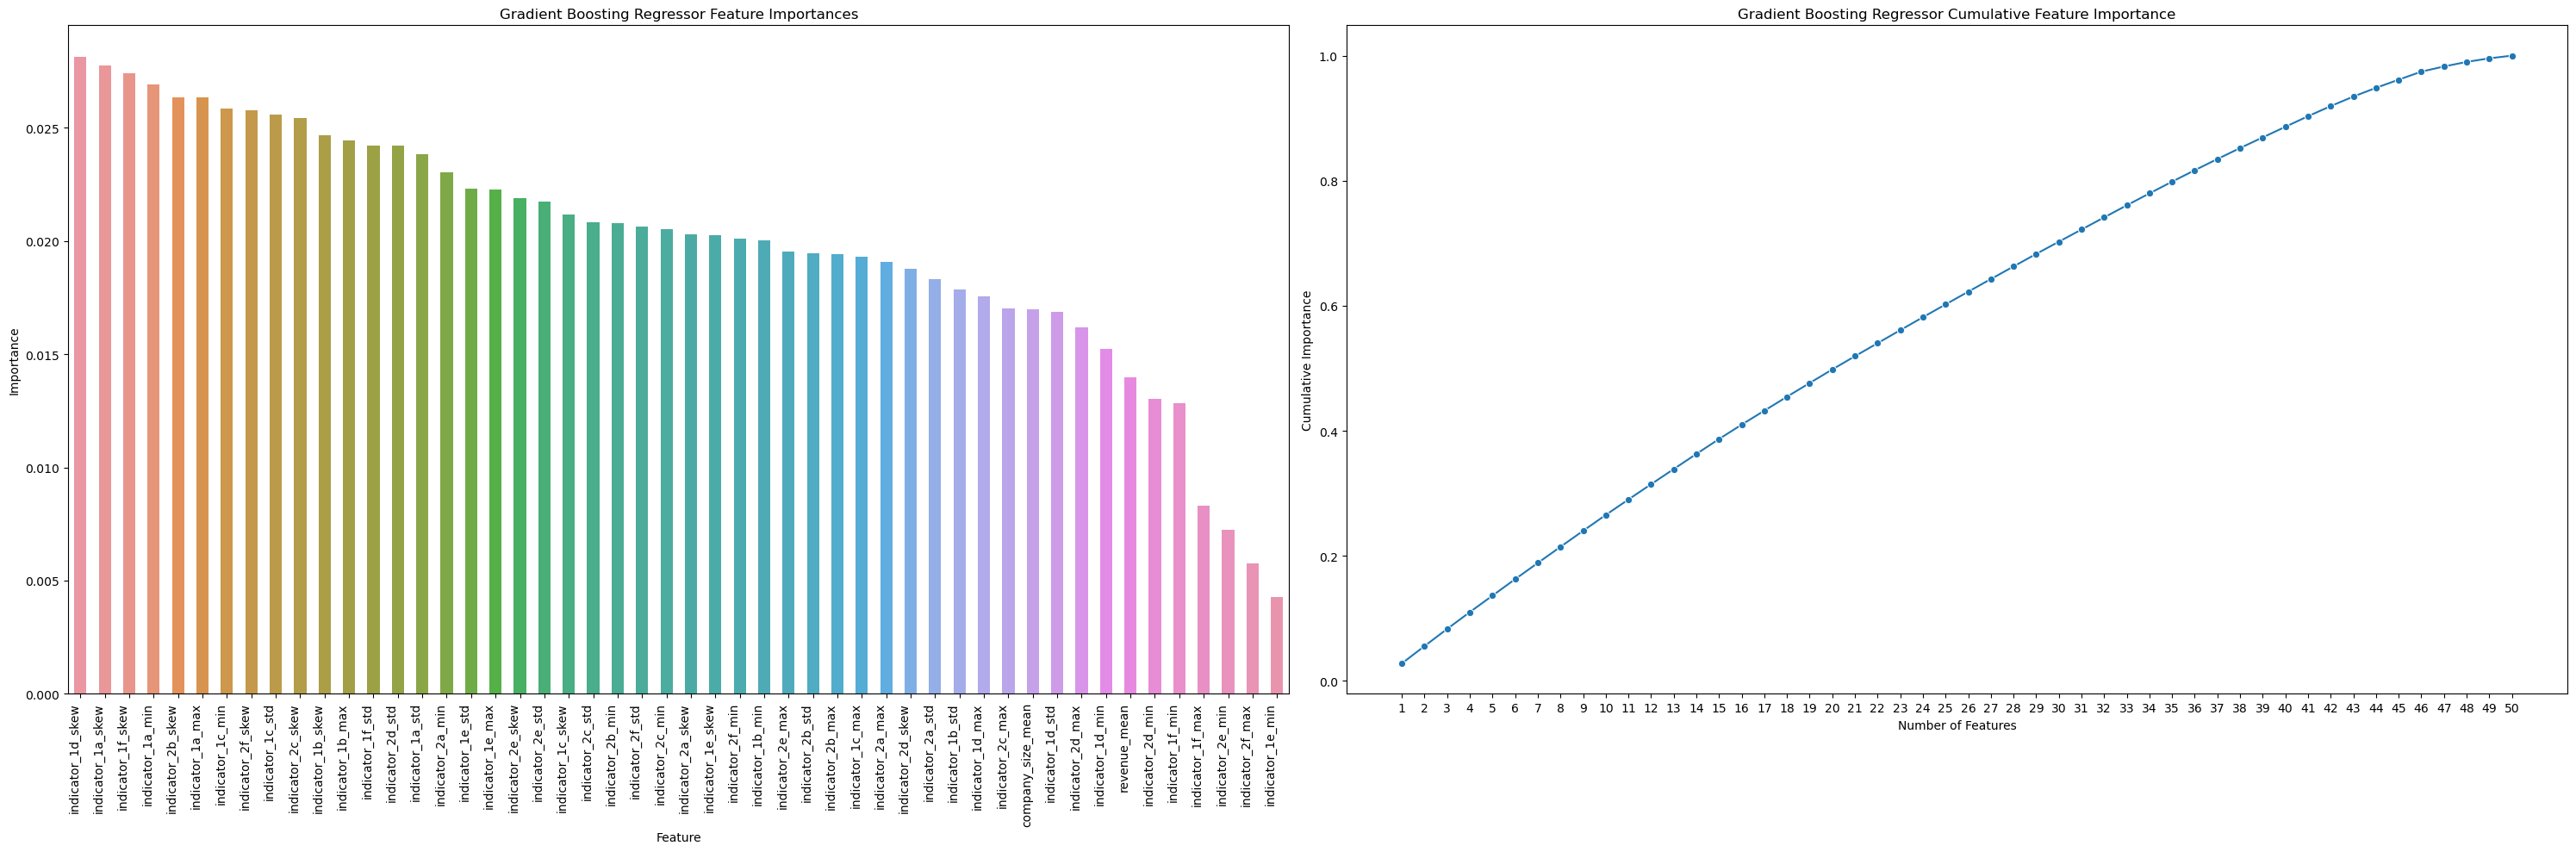

             Feature  Importance  Cumulative Importance
0  indicator_1d_skew    0.028126               0.028126
1  indicator_1a_skew    0.027742               0.055868
2  indicator_1f_skew    0.027413               0.083281
3   indicator_1a_min    0.026901               0.110183
4  indicator_2b_skew    0.026358               0.136541


In [ ]:
# Get feature importances
feature_importances_gbr = best_model_gbr.feature_importances_

# Create a DataFrame for better visualization
features = X_train_reg_scaled_agg.columns
importance_gbr = pd.DataFrame({'Feature': features, 'Importance': feature_importances_gbr})

# Sort the DataFrame by importance and reset the index
importance_gbr = importance_gbr.sort_values(by='Importance', ascending=False)
importance_gbr.reset_index(drop=True, inplace=True)

# Calculate cumulative importance
importance_gbr['Cumulative Importance'] = np.cumsum(importance_gbr['Importance'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# Plot the feature importances
sns.barplot(x='Feature', y='Importance', data=importance_gbr, ax=ax1, width=0.5)
ax1.set_title('Gradient Boosting Regressor Feature Importances')
ax1.tick_params(axis='x', rotation=90)

# Adjust the bar width and spacing
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
ax1.set_xlim(-0.5, len(importance_gbr) - 0.5)

# Plot the cumulative importance
sns.lineplot(x=range(1, len(importance_gbr) + 1), y='Cumulative Importance', data=importance_gbr, marker='o', ax=ax2)
ax2.set_title('Gradient Boosting Regressor Cumulative Feature Importance')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')

# Include all feature indices as x labels
ax2.set_xticks(range(1, len(importance_gbr) + 1))
ax2.set_xticklabels(range(1, len(importance_gbr) + 1))

# Adjust layout to fit labels
plt.tight_layout()
plt.show()

# Print the top 5 features
print(importance_gbr.head())

CNN

In [ ]:
def reshape_for_cnn(data, time_steps, target_col=None):
    X_cnn = []
    y_cnn = []
    indices = []
    for asset_id in data.index.get_level_values('asset_id').unique():
        asset_data = data.loc[asset_id].drop(columns=[target_col]).values if target_col else data.loc[asset_id].values
        if target_col:
            asset_target = data.loc[asset_id][target_col].values
        if len(asset_data) >= time_steps:
            X_cnn.append(asset_data[-time_steps:, :])
            indices.append(asset_id)
            if target_col:
                y_cnn.append(asset_target[-1])
    if target_col:
        return np.array(X_cnn), np.array(y_cnn), indices
    else:
        return np.array(X_cnn), indices

time_steps_cnn = 30

# Combine features and target into a single dataframe for training and validation sets
train_cnn = X_train_reg_scaled.copy()
train_cnn = train_cnn.merge(y_train_reg, left_index = True, right_index = True, how = 'left')

val_cnn = X_val_reg_scaled.copy()
val_cnn = val_cnn.merge(y_val_reg, left_index = True, right_index = True, how = 'left')

# Reshape training and validation data
X_train_cnn, y_train_cnn, train_indices = reshape_for_cnn(train_cnn, time_steps_cnn, target_col = 'return_on_asset')
X_val_cnn, y_val_cnn, val_indices = reshape_for_cnn(val_cnn, time_steps_cnn, target_col = 'return_on_asset')

# Reshape data to add channel dimension for 2D CNN
X_train_cnn = X_train_cnn[..., np.newaxis]
X_val_cnn = X_val_cnn[..., np.newaxis]

In [ ]:
# Initialize the Sequential model and add layers
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(time_steps_cnn, X_train_cnn.shape[2], 1), kernel_regularizer=l1_l2(l1=0.1, l2=0.1)))
#model_cnn.add(ActivityRegularization(l1=0.2, l2=0.2))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu', kernel_regularizer=l1_l2(l1=0.1, l2=0.1)))
#model_cnn.add(ActivityRegularization(l1=0.2, l2=0.2))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))

model_cnn.add(Flatten())

model_cnn.add(Dense(1))

# Compile the model
model_cnn.compile(optimizer=Adam(), loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=200, batch_size=32, validation_data=(X_val_cnn, y_val_cnn), callbacks=[early_stopping])

# Evaluate the model
loss, mae = model_cnn.evaluate(X_val_cnn, y_val_cnn)
y_val_pred_cnn = model_cnn.predict(X_val_cnn)

print(f"CNN Validation Mean Absolute Error: {mae}")

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 44.6049 - mean_absolute_error: 32.7855 - val_loss: 44.7854 - val_mean_absolute_error: 33.4233
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 42.3342 - mean_absolute_error: 31.1097 - val_loss: 43.8939 - val_mean_absolute_error: 33.1051
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 40.0970 - mean_absolute_error: 29.4374 - val_loss: 42.9088 - val_mean_absolute_error: 32.6559
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 37.7161 - mean_absolute_error: 27.5826 - val_loss: 41.7645 - val_mean_absolute_error: 32.0045
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 35.0484 - mean_absolute_error: 25.3974 - val_loss: 40.3939 - val_mean_absolute_error: 31.0849
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 32.0900 - mean_absolute_error: 22.8815 - val_loss: 38.7277 - val_mean_absolute_error: 29.8359
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 29.1474 - mean_absolute_error:

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.9996 - mean_absolute_error: 5.6011 - val_loss: 12.7705 - val_mean_absolute_error: 10.3953
Epoch 46/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7435 - mean_absolute_error: 5.3775 - val_loss: 12.6188 - val_mean_absolute_error: 10.2815
Epoch 47/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9314 - mean_absolute_error: 5.6012 - val_loss: 13.0230 - val_mean_absolute_error: 10.7088
Epoch 48/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0587 - mean_absolute_error: 5.7482 - val_loss: 12.4362 - val_mean_absolute_error: 10.1327
Epoch 49/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4741 - mean_absolute_error: 5.1731 - val_loss: 12.7466 - val_mean_absolute_error: 10.4554
Epoch 50/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7244 - mean_absolute_error: 5.4374 - val_loss: 11.3783 - val_mean_absolute_error: 9.1032
Epoch 51/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7356 - mean_absolute_error: 5.4644 - val_loss: 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2922 - mean_absolute_error: 4.3715 - val_loss: 9.1592 - val_mean_absolute_error: 7.2542
Epoch 90/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0437 - mean_absolute_error: 4.1402 - val_loss: 9.0420 - val_mean_absolute_error: 7.1463
Epoch 91/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.7689 - mean_absolute_error: 3.8736 - val_loss: 9.1384 - val_mean_absolute_error: 7.2445
Epoch 92/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4524 - mean_absolute_error: 4.5589 - val_loss: 9.0172 - val_mean_absolute_error: 7.1294
Epoch 93/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6353 - mean_absolute_error: 4.7508 - val_loss: 9.0808 - val_mean_absolute_error: 7.1967
Epoch 94/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.1177 - mean_absolute_error: 4.2322 - val_loss: 8.9771 - val_mean_absolute_error: 7.0915
Epoch 95/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2295 - mean_absolute_error: 4.3435 - val_loss: 9.1962 - va

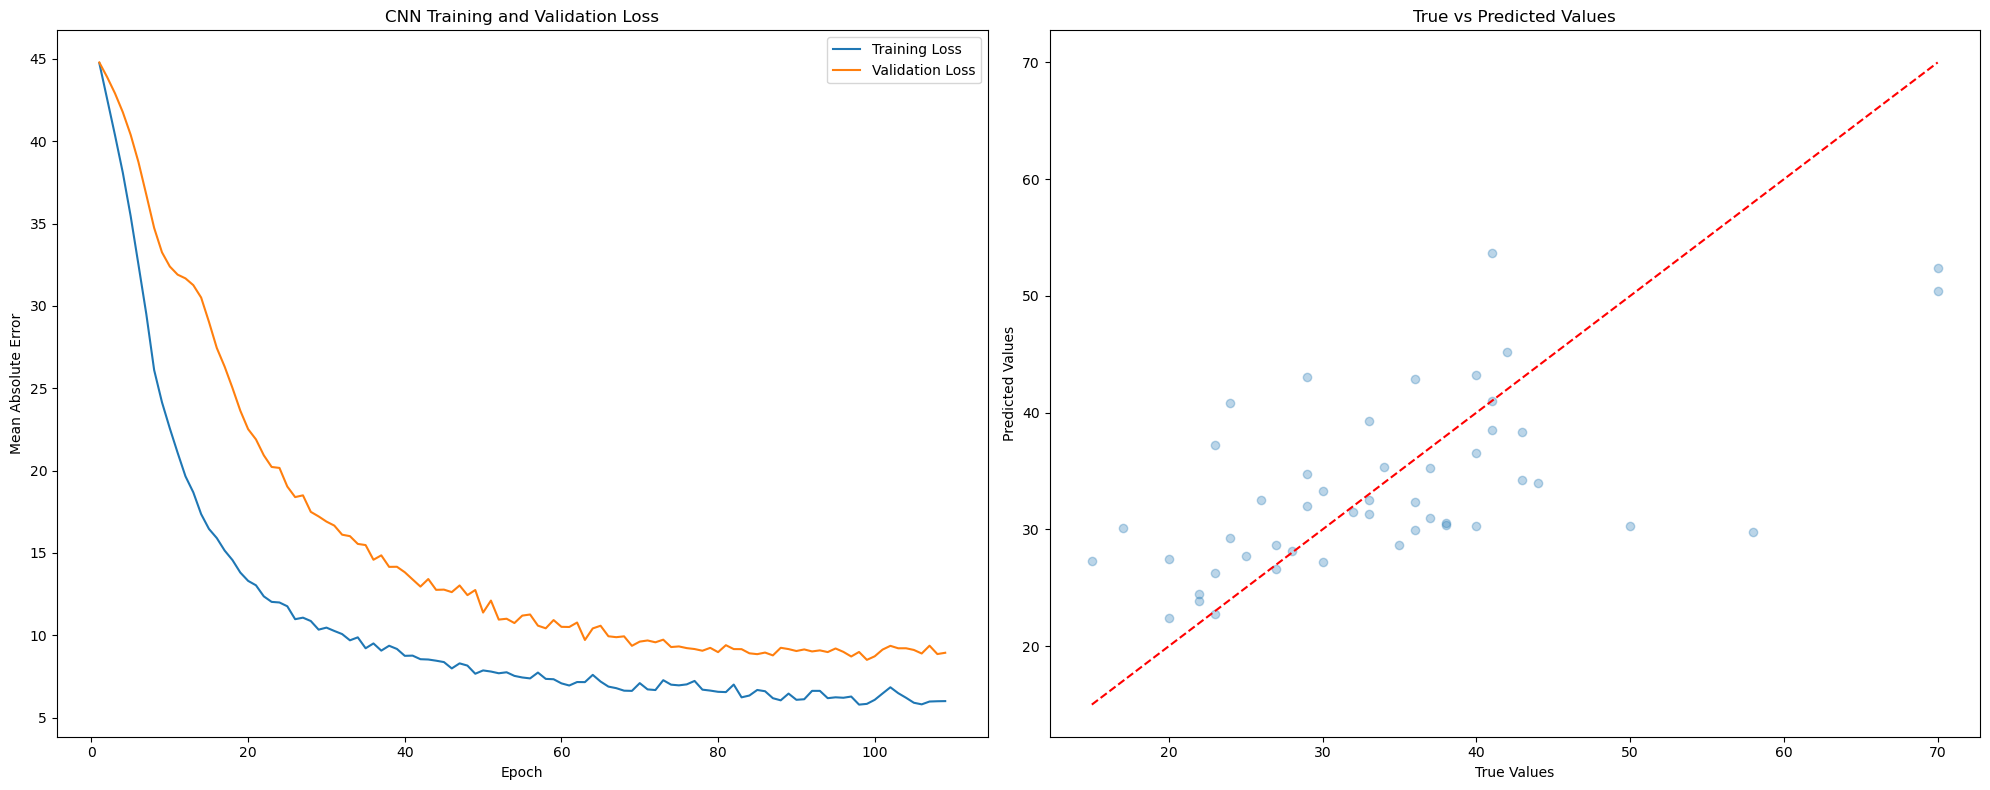

CNN Validation Mean Squared Error: 6.650108337402344


In [ ]:
# Extract loss history
loss_history = history_cnn.history['loss']
val_loss_history = history_cnn.history['val_loss']

# Create a DataFrame for better visualization
epochs = range(1, len(loss_history) + 1)
loss_df = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss_history,
    'Validation Loss': val_loss_history
})

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the loss over epochs
sns.lineplot(x='Epoch', y='Training Loss', data=loss_df, ax=ax1, label='Training Loss')
sns.lineplot(x='Epoch', y='Validation Loss', data=loss_df, ax=ax1, label='Validation Loss')
ax1.set_title('CNN Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Absolute Error')
ax1.legend()

# Plot the true vs predicted values
y_val_pred_cnn_flat = y_val_pred_cnn.flatten()
ax2.scatter(y_val_cnn, y_val_pred_cnn_flat, alpha=0.3)
ax2.plot([y_val_cnn.min(), y_val_cnn.max()], [y_val_cnn.min(), y_val_cnn.max()], 'r--')
ax2.set_title('True vs Predicted Values')
ax2.set_xlabel('True Values')
ax2.set_ylabel('Predicted Values')

# Display the plots
plt.tight_layout()
plt.show()

print(f"CNN Validation Mean Squared Error: {mae}")

Part 4. Predict the Test Set Using the Best Models (LSTM and Gradient Boosting Regressor)

In [ ]:
# Read and preprocess the test set
test = pd.read_csv('test.csv', header=0)
test['timestamp'] = test['timestamp'].apply(parse_timestamp)
test.sort_values(['asset_id', 'timestamp'], ascending=[True, True], inplace=True)
test.reset_index(drop=True, inplace=True)
test.set_index(['asset_id', 'timestamp'], inplace=True)

In [ ]:
# Normalize the test set
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

# Fill NA values with 0
test_scaled.fillna(0, inplace=True)

In [ ]:
test_class_scaled = test_scaled.drop(columns=[feature for feature in col_drop_class if feature not in ('return_on_asset', 'roi')], axis=1)

In [ ]:
# Reshape the test set for LSTM
X_test_rnn = reshape_for_rnn(test_class_scaled, time_steps_rnn)

# Get predictions
y_test_pred_lstm = (model_lstm.predict(X_test_rnn) > 0.5).astype("int32")

3200/3200 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step


In [ ]:
# Initialize an array with the same shape as y_val_class and fill it with zeros
y_test_pred_lstm_full = np.zeros(test_class_scaled.shape[0], dtype=int)
y_test_pred_lstm_full = y_test_pred_lstm_full.reshape(-1, 1)

# Fill in the predictions for each asset
index = 0

for asset_id in test_class_scaled.index.get_level_values('asset_id').unique():
    asset_length = len(test_class_scaled.loc[asset_id])
    y_test_pred_lstm_full[index + time_steps_rnn:index + asset_length] = y_test_pred_lstm[:asset_length - time_steps_rnn]
    y_test_pred_lstm = y_test_pred_lstm[asset_length - time_steps_rnn:]
    index += asset_length

In [ ]:
# Create a DataFrame for predictions
y_test_pred_lstm = pd.DataFrame(y_test_pred_lstm_full, columns=['roi'], index=test_class_scaled.index)

# Merge predictions with the original test data
test_scaled = test_scaled.merge(y_test_pred_lstm, left_index=True, right_index=True, how='left')

# Filter test set based on ROI predictions
test_scaled = test_scaled[test_scaled['roi'] == 1]
test_scaled.drop('roi', axis=1, inplace=True)

In [ ]:
# Engineer the features
test_scaled_agg = test_scaled.groupby('asset_id').agg(agg_dict).reset_index()

# Flatten multi-level column names
test_scaled_agg.set_index('asset_id', inplace = True)
test_scaled_agg.columns = ['_'.join(col).strip() for col in test_scaled_agg.columns.values]

In [ ]:
# Predict the return_on_asset column for test data
y_test_pred_gbr = best_model_gbr.predict(test_scaled_agg)

In [ ]:
test_scaled_agg['prediction'] = y_test_pred_gbr
test_scaled_agg = test_scaled_agg[['prediction']]
test_scaled_agg.reset_index(drop = False, inplace = True)
test_scaled_agg['prediction'] = test_scaled_agg['prediction'].round()

print(test_scaled_agg.head())

                           asset_id  prediction
0  00cdd7262aa74f45b5ff881f6be30577        31.0
1  00ef560475fc4bfebf9dc6c6fce20778        43.0
2  012ebb1178db45f99e6a538ad83120b2        50.0
3  025e3e3d187a46699c9328b95d7fb004        36.0
4  02b965c7262343c5981720073b399ec8        35.0


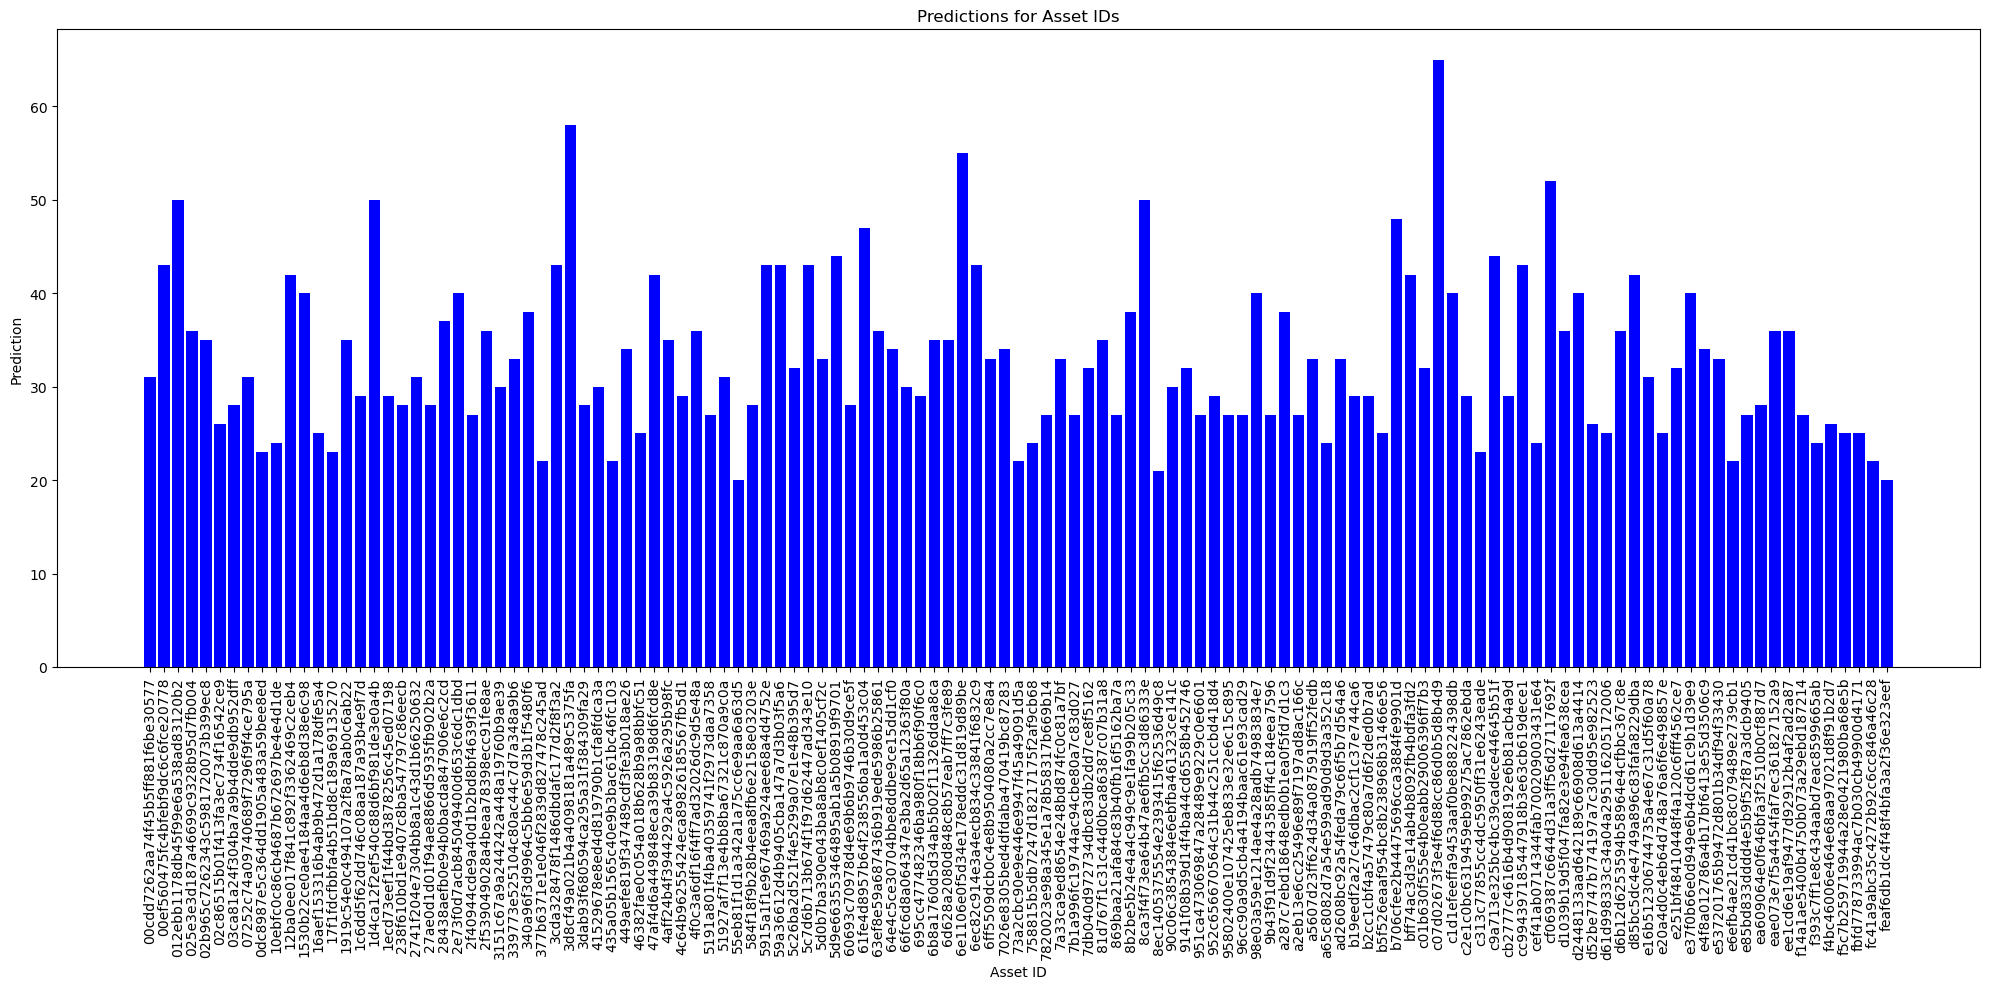

In [ ]:
# Plot the predictions
plt.figure(figsize=(20, 10))
plt.bar(test_scaled_agg['asset_id'], test_scaled_agg['prediction'], color='blue')
plt.xlabel('Asset ID')
plt.ylabel('Prediction')
plt.title('Predictions for Asset IDs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Download the output of model
test_scaled_agg.to_csv('test_output.csv', index=False)
#files.download('test_output.csv')